In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

all_domains = ["Bible", "Opensub", "Wiki"]

comet_json_output = "eval_X_sequence2sequence_bleu_gen_chart_data.json"

df = pd.read_json("data/fig1/%s" % comet_json_output)

per_domain_records = pd.read_json("data/fig1/%s" % comet_json_output, orient="columns", typ="series")

In [10]:
domain_dfs = []

window_size = 5

for domain_record in reversed(per_domain_records):
    domain_df = pd.DataFrame(domain_record)
    plot_name = next("MLE: in-domain (%s)" % domain if "Wiki" in domain else "MLE: out-of-domain (%s)" % domain
                     for domain in all_domains if domain in domain_df["name"].iloc[0])

    reference_value = domain_df["y"].iloc[0]

    domain_df[plot_name] = domain_df["y"]
    domain_df["Update step"] = domain_df.x
    domain_df = domain_df.set_index("Update step", drop=True)
    domain_df = domain_df[plot_name]

    smoothed = domain_df.rolling(window=window_size, center=True).mean()
    normalised = smoothed / reference_value
    domain_df[pd.isna(normalised)] = 1
    domain_df[~pd.isna(normalised)] = normalised[~pd.isna(normalised)]

    domain_df = domain_df.iloc[:-(window_size // 2 + 1)]

    domain_dfs.append(domain_df)

all_df = pd.concat(domain_dfs, axis=1)
all_df

,MLE: in-domain (Wiki),MLE: out-of-domain (Opensub),MLE: out-of-domain (Bible)
Update step,,,
500,1.000000,1.000000,1.000000
1000,1.000000,1.000000,1.000000
1500,1.067757,0.962101,0.952630
2000,1.082330,0.945424,0.942398
2500,1.084858,0.936531,0.937660
...,...,...,...
31000,1.069996,0.761789,0.631541
31500,1.070331,0.782102,0.630856
32000,1.069256,0.788968,0.625680


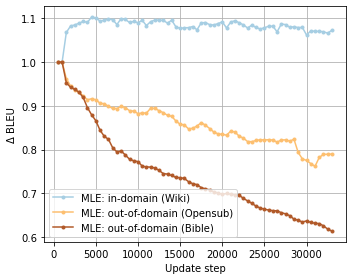

In [14]:
all_df.plot(grid=True, colormap="Paired", figsize=(5, 4), marker=".")

plt.xlabel("Update step")
plt.ylabel("Δ BLEU")

plt.tight_layout()
plt.savefig("MLE_forgetting.pdf", format="pdf", dpi=300)